In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from PIL import Image
import Helper

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

IndexError: index 2 is out of bounds for dimension 0 with size 2

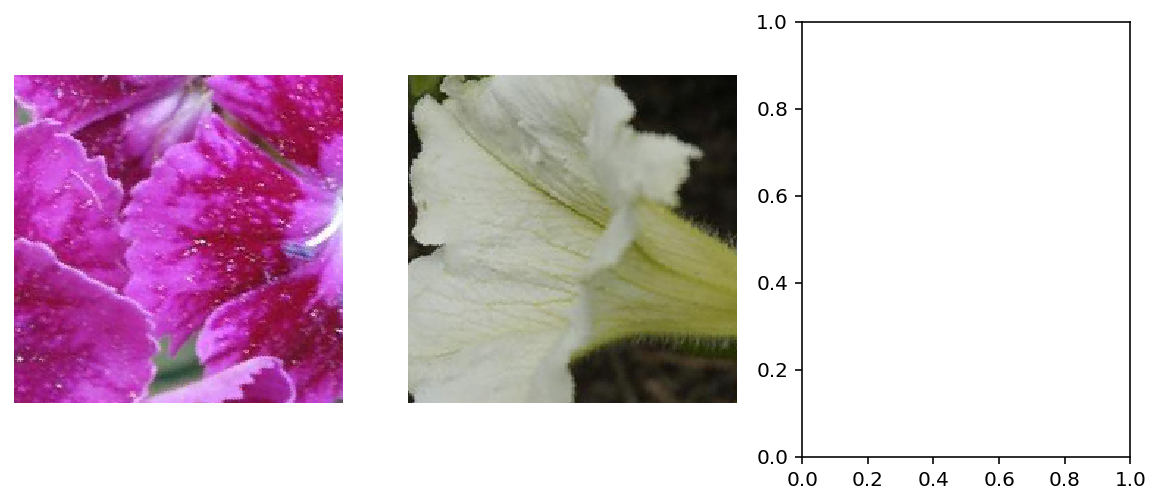

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms=
train_transforms=transforms.Compose([transforms.RandomRotation(30),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_data=datasets.ImageFolder(data_dir +'/train',transform=train_transforms)
test_data=datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
#data_loaders=
trainloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=2,shuffle=False)
validloader= torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False)

#A test to see if I am loading the images correctly


images, labels = next(iter(trainloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=3)
for i in range(3):
    ax = axes[i]
    Helper.imshow(images[i], ax=ax)

In [4]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device



from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu',nn.ReLU()),
                          ('drop',nn.Dropout(0.5)),
                          ('fc2',nn.Linear(4096,102)),
                          ('softmax',nn.LogSoftmax(dim=1))
    ]))
    
model.classifier = classifier
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)
print(device)


cuda:0


In [ ]:

# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

print_every=32
steps =0
print("Initialize training .....\n")
epochs = 8

for e in range(epochs):
    running_loss = 0
    model.train() 
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
     
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(testloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            model.train()

print("\nTraining complete")

Initialize training .....

Epoch: 1/8 |  Training Loss: 307.8693 |  Validation Loss: 74.6917 |  Validation Accuracy: 0.0146
Epoch: 1/8 |  Training Loss: 81.2026 |  Validation Loss: 49.3827 |  Validation Accuracy: 0.0402
Epoch: 1/8 |  Training Loss: 63.7863 |  Validation Loss: 33.4835 |  Validation Accuracy: 0.0390
Epoch: 1/8 |  Training Loss: 30.7181 |  Validation Loss: 9.9780 |  Validation Accuracy: 0.0659
Epoch: 1/8 |  Training Loss: 12.8521 |  Validation Loss: 9.3268 |  Validation Accuracy: 0.0317
Epoch: 1/8 |  Training Loss: 8.2830 |  Validation Loss: 5.5968 |  Validation Accuracy: 0.0512
Epoch: 1/8 |  Training Loss: 7.7429 |  Validation Loss: 19.0769 |  Validation Accuracy: 0.0207
Epoch: 1/8 |  Training Loss: 10.7782 |  Validation Loss: 9.8345 |  Validation Accuracy: 0.0256
